# Method 6 - Best Ideas High Minus Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
low_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

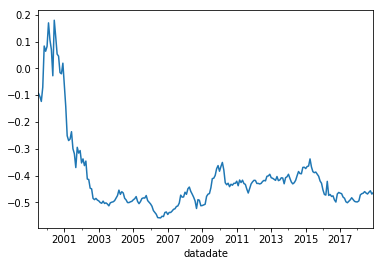

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.063689
2000-12-31   -0.041880
2001-12-31   -0.319885
2002-12-31   -0.266624
2003-12-31   -0.004268
2004-12-31   -0.004889
2005-12-31   -0.007120
2006-12-31   -0.072418
2007-12-31    0.120931
2008-12-31   -0.063184
2009-12-31    0.307717
2010-12-31   -0.104301
2011-12-31    0.010090
2012-12-31    0.049057
2013-12-31   -0.015157
2014-12-31    0.059556
2015-12-31   -0.094881
2016-12-31   -0.060009
2017-12-31   -0.065453
2018-12-31    0.069028
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     8.910
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-06
Time:                        14:31:38   Log-Likelihood:                 457.33
No. Observations:                 234   AIC:                            -904.7
Df Residuals:                     229   BIC:                            -887.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.002     -1.090      0.277      -0.007       0.002
mktrf          0.0941      0.065      1.456      0.147      -0.033       0.221
me             0.2501      0.075      3.327      0.001       0.102       0.398
ia            -0.1824      0.114     -1.597      0.112      -0.407       0.043
roe           -0.1117      0.098     -1.143      0.254      -0.304       0.081
==============================================================================
Omnibus:                       44.246   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.427
Skew:                           0.582   Prob(JB):                     1.52e-50
Kurtosis:                       7.709   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     4.533
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00153
Time:                        14:31:38   Log-Likelihood:                 457.33
No. Observations:                 234   AIC:                            -904.7
Df Residuals:                     229   BIC:                            -887.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.003     -0.971      0.332      -0.008       0.003
mktrf          0.0941      0.087      1.087      0.277      -0.076       0.264
me             0.2501      0.121      2.061      0.039       0.012       0.488
ia            -0.1824      0.134     -1.364      0.173      -0.445       0.080
roe           -0.1117      0.117     -0.957      0.339      -0.341       0.117
==============================================================================
Omnibus:                       44.246   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.427
Skew:                           0.582   Prob(JB):                     1.52e-50
Kurtosis:                       7.709   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     6.451
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.18e-05
Time:                        14:31:38   Log-Likelihood:                 457.33
No. Observations:                 234   AIC:                            -904.7
Df Residuals:                     229   BIC:                            -887.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.003     -0.896      0.370      -0.008       0.003
mktrf          0.0941      0.081      1.157      0.247      -0.065       0.253
me             0.2501      0.127      1.974      0.048       0.002       0.498
ia            -0.1824      0.128     -1.421      0.155      -0.434       0.069
roe           -0.1117      0.119     -0.936      0.349      -0.346       0.122
==============================================================================
Omnibus:                       44.246   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.427
Skew:                           0.582   Prob(JB):                     1.52e-50
Kurtosis:                       7.709   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     9.550
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.75e-08
Time:                        14:31:38   Log-Likelihood:                 462.65
No. Observations:                 234   AIC:                            -913.3
Df Residuals:                     228   BIC:                            -892.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.002     -1.002      0.318      -0.007       0.002
mktrf          0.1139      0.063      1.796      0.074      -0.011       0.239
smb            0.2029      0.084      2.424      0.016       0.038       0.368
hml           -0.2340      0.099     -2.371      0.019      -0.428      -0.040
rmw           -0.1810      0.112     -1.622      0.106      -0.401       0.039
cma            0.1488      0.142      1.049      0.295      -0.131       0.428
==============================================================================
Omnibus:                       35.413   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.851
Skew:                           0.478   Prob(JB):                     2.89e-33
Kurtosis:                       6.802   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     8.391
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.65e-07
Time:                        14:31:38   Log-Likelihood:                 462.65
No. Observations:                 234   AIC:                            -913.3
Df Residuals:                     228   BIC:                            -892.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.002     -0.960      0.337      -0.007       0.002
mktrf          0.1139      0.068      1.681      0.093      -0.019       0.247
smb            0.2029      0.121      1.678      0.093      -0.034       0.440
hml           -0.2340      0.139     -1.688      0.091      -0.506       0.038
rmw           -0.1810      0.108     -1.675      0.094      -0.393       0.031
cma            0.1488      0.146      1.018      0.308      -0.138       0.435
==============================================================================
Omnibus:                       35.413   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.851
Skew:                           0.478   Prob(JB):                     2.89e-33
Kurtosis:                       6.802   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     10.05
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-08
Time:                        14:31:38   Log-Likelihood:                 462.65
No. Observations:                 234   AIC:                            -913.3
Df Residuals:                     228   BIC:                            -892.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.867      0.386      -0.008       0.003
mktrf          0.1139      0.072      1.584      0.113      -0.027       0.255
smb            0.2029      0.120      1.688      0.091      -0.033       0.438
hml           -0.2340      0.155     -1.506      0.132      -0.539       0.071
rmw           -0.1810      0.128     -1.410      0.159      -0.433       0.071
cma            0.1488      0.136      1.094      0.274      -0.118       0.415
==============================================================================
Omnibus:                       35.413   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.851
Skew:                           0.478   Prob(JB):                     2.89e-33
Kurtosis:                       6.802   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     11.96
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.68e-09
Time:                        14:31:38   Log-Likelihood:                 462.60
No. Observations:                 234   AIC:                            -915.2
Df Residuals:                     229   BIC:                            -897.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.002     -1.385      0.167      -0.008       0.001
mktrf          0.1445      0.058      2.483      0.014       0.030       0.259
smb            0.2940      0.073      4.049      0.000       0.151       0.437
hml           -0.1701      0.072     -2.359      0.019      -0.312      -0.028
umd            0.0115      0.047      0.243      0.808      -0.082       0.105
==============================================================================
Omnibus:                       29.399   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.461
Skew:                           0.392   Prob(JB):                     1.03e-24
Kurtosis:                       6.273   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     5.208
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000494
Time:                        14:31:38   Log-Likelihood:                 462.60
No. Observations:                 234   AIC:                            -915.2
Df Residuals:                     229   BIC:                            -897.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.002     -1.324      0.185      -0.008       0.001
mktrf          0.1445      0.072      2.018      0.044       0.004       0.285
smb            0.2940      0.100      2.935      0.003       0.098       0.490
hml           -0.1701      0.094     -1.818      0.069      -0.354       0.013
umd            0.0115      0.078      0.148      0.883      -0.141       0.164
==============================================================================
Omnibus:                       29.399   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.461
Skew:                           0.392   Prob(JB):                     1.03e-24
Kurtosis:                       6.273   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     5.667
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000229
Time:                        14:31:38   Log-Likelihood:                 462.60
No. Observations:                 234   AIC:                            -915.2
Df Residuals:                     229   BIC:                            -897.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.002     -1.254      0.210      -0.008       0.002
mktrf          0.1445      0.068      2.113      0.035       0.010       0.278
smb            0.2940      0.084      3.498      0.000       0.129       0.459
hml           -0.1701      0.089     -1.905      0.057      -0.345       0.005
umd            0.0115      0.071      0.163      0.871      -0.127       0.150
==============================================================================
Omnibus:                       29.399   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.461
Skew:                           0.392   Prob(JB):                     1.03e-24
Kurtosis:                       6.273   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     6.636
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.67e-05
Time:                        14:31:38   Log-Likelihood:                 214.93
No. Observations:                 120   AIC:                            -419.9
Df Residuals:                     115   BIC:                            -405.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.004     -1.383      0.169      -0.013       0.002
mktrf          0.1173      0.106      1.104      0.272      -0.093       0.328
me             0.3564      0.105      3.396      0.001       0.149       0.564
ia            -0.3755      0.164     -2.285      0.024      -0.701      -0.050
roe            0.0419      0.145      0.288      0.774      -0.246       0.330
==============================================================================
Omnibus:                       21.655   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.500
Skew:                           0.621   Prob(JB):                     3.27e-13
Kurtosis:                       6.156   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     4.347
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00261
Time:                        14:31:39   Log-Likelihood:                 214.93
No. Observations:                 120   AIC:                            -419.9
Df Residuals:                     115   BIC:                            -405.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.004     -1.263      0.207      -0.014       0.003
mktrf          0.1173      0.152      0.773      0.440      -0.180       0.415
me             0.3564      0.145      2.460      0.014       0.072       0.640
ia            -0.3755      0.152     -2.469      0.014      -0.674      -0.077
roe            0.0419      0.166      0.252      0.801      -0.284       0.368
==============================================================================
Omnibus:                       21.655   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.500
Skew:                           0.621   Prob(JB):                     3.27e-13
Kurtosis:                       6.156   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     7.855
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.24e-05
Time:                        14:31:39   Log-Likelihood:                 214.93
No. Observations:                 120   AIC:                            -419.9
Df Residuals:                     115   BIC:                            -405.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.005     -1.153      0.249      -0.015       0.004
mktrf          0.1173      0.156      0.751      0.453      -0.189       0.424
me             0.3564      0.153      2.323      0.020       0.056       0.657
ia            -0.3755      0.115     -3.261      0.001      -0.601      -0.150
roe            0.0419      0.172      0.243      0.808      -0.296       0.379
==============================================================================
Omnibus:                       21.655   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.500
Skew:                           0.621   Prob(JB):                     3.27e-13
Kurtosis:                       6.156   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     8.209
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-06
Time:                        14:31:39   Log-Likelihood:                 220.92
No. Observations:                 120   AIC:                            -429.8
Df Residuals:                     114   BIC:                            -413.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051      0.004     -1.324      0.188      -0.013       0.003
mktrf          0.1850      0.107      1.728      0.087      -0.027       0.397
smb            0.3454      0.121      2.848      0.005       0.105       0.586
hml           -0.4977      0.149     -3.350      0.001      -0.792      -0.203
rmw            0.1191      0.175      0.680      0.498      -0.228       0.466
cma            0.1431      0.192      0.746      0.457      -0.237       0.523
==============================================================================
Omnibus:                       10.383   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               20.798
Skew:                           0.266   Prob(JB):                     3.05e-05
Kurtosis:                       4.969   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     11.57
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.77e-09
Time:                        14:31:39   Log-Likelihood:                 220.92
No. Observations:                 120   AIC:                            -429.8
Df Residuals:                     114   BIC:                            -413.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051      0.004     -1.217      0.223      -0.013       0.003
mktrf          0.1850      0.124      1.491      0.136      -0.058       0.428
smb            0.3454      0.158      2.184      0.029       0.035       0.655
hml           -0.4977      0.169     -2.951      0.003      -0.828      -0.167
rmw            0.1191      0.183      0.652      0.514      -0.239       0.477
cma            0.1431      0.208      0.689      0.491      -0.264       0.550
==============================================================================
Omnibus:                       10.383   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               20.798
Skew:                           0.266   Prob(JB):                     3.05e-05
Kurtosis:                       4.969   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     18.83
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.31e-13
Time:                        14:31:39   Log-Likelihood:                 220.92
No. Observations:                 120   AIC:                            -429.8
Df Residuals:                     114   BIC:                            -413.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051      0.005     -1.036      0.300      -0.015       0.005
mktrf          0.1850      0.133      1.391      0.164      -0.076       0.446
smb            0.3454      0.160      2.160      0.031       0.032       0.659
hml           -0.4977      0.198     -2.517      0.012      -0.885      -0.110
rmw            0.1191      0.213      0.559      0.577      -0.299       0.537
cma            0.1431      0.208      0.689      0.491      -0.264       0.550
==============================================================================
Omnibus:                       10.383   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               20.798
Skew:                           0.266   Prob(JB):                     3.05e-05
Kurtosis:                       4.969   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     10.68
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.15e-07
Time:                        14:31:39   Log-Likelihood:                 221.42
No. Observations:                 120   AIC:                            -432.8
Df Residuals:                     115   BIC:                            -418.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.004     -1.194      0.235      -0.012       0.003
mktrf          0.1470      0.089      1.658      0.100      -0.029       0.323
smb            0.3012      0.101      2.983      0.003       0.101       0.501
hml           -0.3050      0.101     -3.016      0.003      -0.505      -0.105
umd            0.0441      0.062      0.707      0.481      -0.079       0.168
==============================================================================
Omnibus:                        9.187   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               16.665
Skew:                           0.252   Prob(JB):                     0.000241
Kurtosis:                       4.754   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     9.174
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-06
Time:                        14:31:39   Log-Likelihood:                 221.42
No. Observations:                 120   AIC:                            -432.8
Df Residuals:                     115   BIC:                            -418.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.003     -1.267      0.205      -0.011       0.002
mktrf          0.1470      0.091      1.608      0.108      -0.032       0.326
smb            0.3012      0.106      2.829      0.005       0.093       0.510
hml           -0.3050      0.094     -3.251      0.001      -0.489      -0.121
umd            0.0441      0.094      0.471      0.637      -0.139       0.227
==============================================================================
Omnibus:                        9.187   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               16.665
Skew:                           0.252   Prob(JB):                     0.000241
Kurtosis:                       4.754   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     12.98
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.37e-09
Time:                        14:31:39   Log-Likelihood:                 221.42
No. Observations:                 120   AIC:                            -432.8
Df Residuals:                     115   BIC:                            -418.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.004     -1.177      0.239      -0.012       0.003
mktrf          0.1470      0.082      1.787      0.074      -0.014       0.308
smb            0.3012      0.090      3.339      0.001       0.124       0.478
hml           -0.3050      0.062     -4.923      0.000      -0.426      -0.184
umd            0.0441      0.085      0.520      0.603      -0.122       0.210
==============================================================================
Omnibus:                        9.187   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               16.665
Skew:                           0.252   Prob(JB):                     0.000241
Kurtosis:                       4.754   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     4.783
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00136
Time:                        14:31:39   Log-Likelihood:                 264.41
No. Observations:                 114   AIC:                            -518.8
Df Residuals:                     109   BIC:                            -505.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.699e-05      0.002     -0.040      0.968      -0.005       0.005
mktrf          0.1091      0.072      1.524      0.130      -0.033       0.251
me            -0.0256      0.110     -0.232      0.817      -0.245       0.193
ia             0.2558      0.153      1.670      0.098      -0.048       0.559
roe           -0.3676      0.135     -2.730      0.007      -0.634      -0.101
==============================================================================
Omnibus:                        5.978   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                6.956
Skew:                          -0.296   Prob(JB):                       0.0309
Kurtosis:                       4.055   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     5.172
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000747
Time:                        14:31:39   Log-Likelihood:                 264.41
No. Observations:                 114   AIC:                            -518.8
Df Residuals:                     109   BIC:                            -505.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.699e-05      0.002     -0.042      0.967      -0.005       0.004
mktrf          0.1091      0.108      1.009      0.313      -0.103       0.321
me            -0.0256      0.145     -0.176      0.860      -0.311       0.260
ia             0.2558      0.161      1.589      0.112      -0.060       0.571
roe           -0.3676      0.165     -2.231      0.026      -0.690      -0.045
==============================================================================
Omnibus:                        5.978   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                6.956
Skew:                          -0.296   Prob(JB):                       0.0309
Kurtosis:                       4.055   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     6.878
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.64e-05
Time:                        14:31:39   Log-Likelihood:                 264.41
No. Observations:                 114   AIC:                            -518.8
Df Residuals:                     109   BIC:                            -505.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.699e-05      0.002     -0.044      0.965      -0.004       0.004
mktrf          0.1091      0.109      1.003      0.316      -0.104       0.322
me            -0.0256      0.151     -0.169      0.866      -0.323       0.271
ia             0.2558      0.166      1.537      0.124      -0.070       0.582
roe           -0.3676      0.163     -2.251      0.024      -0.688      -0.048
==============================================================================
Omnibus:                        5.978   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                6.956
Skew:                          -0.296   Prob(JB):                       0.0309
Kurtosis:                       4.055   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     3.797
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00331
Time:                        14:31:39   Log-Likelihood:                 264.43
No. Observations:                 114   AIC:                            -516.9
Df Residuals:                     108   BIC:                            -500.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.237      0.813      -0.005       0.004
mktrf          0.1096      0.069      1.600      0.113      -0.026       0.245
smb           -0.0079      0.111     -0.071      0.943      -0.228       0.213
hml            0.1966      0.142      1.386      0.169      -0.085       0.478
rmw           -0.2399      0.174     -1.381      0.170      -0.584       0.104
cma            0.1885      0.221      0.855      0.395      -0.249       0.626
==============================================================================
Omnibus:                        7.803   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               13.368
Skew:                          -0.200   Prob(JB):                      0.00125
Kurtosis:                       4.629   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     3.619
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00458
Time:                        14:31:39   Log-Likelihood:                 264.43
No. Observations:                 114   AIC:                            -516.9
Df Residuals:                     108   BIC:                            -500.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.241      0.809      -0.005       0.004
mktrf          0.1096      0.093      1.177      0.239      -0.073       0.292
smb           -0.0079      0.136     -0.058      0.953      -0.274       0.258
hml            0.1966      0.104      1.900      0.057      -0.006       0.400
rmw           -0.2399      0.203     -1.184      0.236      -0.637       0.157
cma            0.1885      0.183      1.032      0.302      -0.169       0.546
==============================================================================
Omnibus:                        7.803   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               13.368
Skew:                          -0.200   Prob(JB):                      0.00125
Kurtosis:                       4.629   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     4.401
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00110
Time:                        14:31:39   Log-Likelihood:                 264.43
No. Observations:                 114   AIC:                            -516.9
Df Residuals:                     108   BIC:                            -500.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.251      0.802      -0.005       0.004
mktrf          0.1096      0.099      1.108      0.268      -0.084       0.304
smb           -0.0079      0.133     -0.059      0.953      -0.269       0.253
hml            0.1966      0.095      2.060      0.039       0.010       0.384
rmw           -0.2399      0.182     -1.319      0.187      -0.596       0.117
cma            0.1885      0.161      1.174      0.240      -0.126       0.503
==============================================================================
Omnibus:                        7.803   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               13.368
Skew:                          -0.200   Prob(JB):                      0.00125
Kurtosis:                       4.629   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     4.299
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00287
Time:                        14:31:39   Log-Likelihood:                 263.55
No. Observations:                 114   AIC:                            -517.1
Df Residuals:                     109   BIC:                            -503.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.222      0.825      -0.005       0.004
mktrf          0.1129      0.068      1.652      0.101      -0.023       0.248
smb            0.0467      0.107      0.439      0.662      -0.164       0.258
hml            0.2700      0.110      2.462      0.015       0.053       0.487
umd           -0.0675      0.083     -0.816      0.416      -0.232       0.096
==============================================================================
Omnibus:                        7.687   Durbin-Watson:                   2.172
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               13.506
Skew:                          -0.171   Prob(JB):                      0.00117
Kurtosis:                       4.651   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     5.801
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000286
Time:                        14:31:39   Log-Likelihood:                 263.55
No. Observations:                 114   AIC:                            -517.1
Df Residuals:                     109   BIC:                            -503.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.003     -0.210      0.833      -0.006       0.004
mktrf          0.1129      0.098      1.151      0.250      -0.079       0.305
smb            0.0467      0.140      0.334      0.738      -0.227       0.320
hml            0.2700      0.112      2.412      0.016       0.051       0.489
umd           -0.0675      0.062     -1.092      0.275      -0.189       0.054
==============================================================================
Omnibus:                        7.687   Durbin-Watson:                   2.172
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               13.506
Skew:                          -0.171   Prob(JB):                      0.00117
Kurtosis:                       4.651   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     6.964
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.97e-05
Time:                        14:31:39   Log-Likelihood:                 263.55
No. Observations:                 114   AIC:                            -517.1
Df Residuals:                     109   BIC:                            -503.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.222      0.824      -0.005       0.004
mktrf          0.1129      0.103      1.092      0.275      -0.090       0.315
smb            0.0467      0.137      0.341      0.733      -0.222       0.315
hml            0.2700      0.122      2.220      0.026       0.032       0.508
umd           -0.0675      0.055     -1.224      0.221      -0.176       0.041
==============================================================================
Omnibus:                        7.687   Durbin-Watson:                   2.172
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               13.506
Skew:                          -0.171   Prob(JB):                      0.00117
Kurtosis:                       4.651   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""